# Introduction to EEG Spectrogram Generation

In this notebook, we focus on the generation of spectrograms from EEG data with the MNE library. EEG recordings capture the electrical activity of the brain, offering valuable insights into neurological phenomena such as seizures, cognitive processes, and sleep stages.

Our main goal is to establish a reliable pipeline for transforming raw EEG signals into spectrograms. Spectrograms provide a visual depiction of the frequency distribution of EEG signals over time, enabling the identification of patterns, anomalies, and unique features in the data.

Throughout this notebook, we harness the power of the MNE Python library, renowned for its extensive capabilities in EEG/MEG data analysis. Leveraging MNE, we will explore various montage configurations, define frequency ranges, and utilize wavelet transforms to generate spectrograms.

For an introductory experience with MNE, you can start with my first notebook available [here](https://www.kaggle.com/code/theeventhorizons/understanding-the-basics-of-mne).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tqdm as tqdm
import mne
from mne.time_frequency import tfr_morlet
import cv2
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

data_train_path = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'

# Read the data

In [2]:
# Read the data
data = pd.read_csv(data_train_path)

# Copy the Data
df = data.copy()

# Observe few lines 
print(df.head())

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [3]:
# Shape of the data
print('The shape of df is:', df.shape)

The shape of df is: (106800, 15)


In [4]:
# Create Target
Target = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

# Montages Used

In EEG (Electroencephalography), a montage refers to the configuration of electrodes used to record brain activity. It's crucial for manipulating raw EEG data to enhance signal quality and extract specific information. One common goal of montage design is to reduce noise and artifacts in the EEG signal, improving clarity and accuracy. 

Montages come in various types, including bipolar and referential configurations, which can augment the number of spectrograms generated (data generation) for the future machine learning models. Here, we introduce some of these montages, although we'll only utilize the double banana montage in subsequent notebooks.

- ## The Bipolar montages

Bipolar montages are used in electroencephalography (EEG) to detect and record the differences in electrical potential between two adjacent electrodes on the scalp. They are often used to capture local variations in brain activity and to identify sources of abnormal electrical activity in the brain.

In general, bipolar montages are useful for:

1. Precise localization: They allow for the detection of subtle changes in electrical potential between two specific points on the scalp, which can help accurately localize abnormal brain activity associated with conditions such as epilepsy or other neurological disorders.

2. Noise reduction: By subtracting the signals recorded by two adjacent electrodes, bipolar montages can reduce artifacts and noise that may interfere with EEG analysis, thereby improving the overall quality of the recorded signal.

3. Differentiation of activity sources: By measuring the potential differences between specific pairs of electrodes, bipolar montages enable the differentiation of different sources of brain activity and mapping their spatial distribution on the scalp.


### 1. The Bipolar double banana montage or longitudinal montage

The "double banana" montage, also known as the longitudinal bipolar montage, is a widely used configuration in EEG electrode placement. In this montage, electrodes are arranged in series, and the channels of electrodes placed in series are subtracted from each other. This arrangement offers versatility and is commonly employed in EEG recordings.

The placement of electrodes and the selection of electrodes in the montage can significantly influence EEG readings. Electrodes are typically positioned according to the 10-20 system, where they are evenly spaced between anatomical landmarks such as the nasion, inion, and preauricular points. Adjusting the distance between electrodes and the number of electrodes used aims to effectively localize the seizure onset zone (SOZ) in EEG recordings.

EEGs play a crucial role not only in diagnosing epilepsy but also in identifying epileptic brain activity patterns and determining the type of epilepsy. Different types of epilepsy exhibit distinct characteristics, including generalized or localized seizures, and may be idiopathic, cryptogenic, or symptomatic. These epileptic activities are associated with various brainwave patterns, such as delta, theta, alpha, and beta waves. Ensuring accuracy in EEG diagnostics involves calibrating montages to reduce noise and artifacts, with evaluations based on band power.

In [5]:
NAMES_BANANA = ['LL','LP','RP','RR','BC']

FEATS_BANANA = [['Fp1','F7','T3','T5','O1'],
                ['Fp1','F3','C3','P3','O1'],
                ['Fp2','F8','T4','T6','O2'],
                ['Fp2','F4','C4','P4','O2'],
                ['Fz','Cz','Pz']]

DIC_BANANA = {}
for name, feat in zip(NAMES_BANANA,FEATS_BANANA):
    DIC_BANANA[name]=feat


DIC_BANANA_SPEC = {}
for name, feat in zip(NAMES_BANANA, FEATS_BANANA):
    ch_names = []
    for kk in range(len(feat)-1):
        # COMPUTE PAIR DIFFERENCES
        ch_names.append(f'{feat[kk]}-{feat[kk+1]}')
    DIC_BANANA_SPEC[name] = ch_names

print(DIC_BANANA_SPEC)

{'LL': ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1'], 'LP': ['Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1'], 'RP': ['Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2'], 'RR': ['Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'], 'BC': ['Fz-Cz', 'Cz-Pz']}


### 2. The transverse bipolar montage

The transverse montage, a form of bipolar montage, aims to localize the peak discharge in the left-to-right direction. It involves linking adjacent electrodes in a chain starting from electrode F7. While effective in certain localization tasks, transverse montages have drawbacks. In-phase cancellation may occur when synchronous waveforms lead to false localization. Additionally, bipolar montages, including the transverse type, are prone to the end-of-chain phenomenon, where the last electrode in a chain produces a downward deflection without a phase reversal. To address this, three chains were grouped instead of five.

In [6]:
NAMES_TRANSVERSE = ['Tr1','Tr2','Tr3','Tr4','Tr5']

FEATS_TRANSVERSE = [['F7','Fp1','Fp2','F8'],
                    ['F7','F3','Fz', 'F4','F8'],
                    ['T3','C3','Cz','C4','T4'],
                    ['T5','P3','Pz','P4','T6'],
                    ['T5','O1','O2','T6']]

DIC_TRANSVERSE = {}
for name, feat in zip(NAMES_TRANSVERSE,FEATS_TRANSVERSE):
    DIC_TRANSVERSE[name]=feat


DIC_TRANSVERSE_SPEC = {}
for name, feat in zip(NAMES_TRANSVERSE, FEATS_TRANSVERSE):
    ch_names = []
    for kk in range(len(feat)-1):
        # COMPUTE PAIR DIFFERENCES
        ch_names.append(f'{feat[kk]}-{feat[kk+1]}')
    DIC_TRANSVERSE_SPEC[name] = ch_names

print(DIC_TRANSVERSE_SPEC)

{'Tr1': ['F7-Fp1', 'Fp1-Fp2', 'Fp2-F8'], 'Tr2': ['F7-F3', 'F3-Fz', 'Fz-F4', 'F4-F8'], 'Tr3': ['T3-C3', 'C3-Cz', 'Cz-C4', 'C4-T4'], 'Tr4': ['T5-P3', 'P3-Pz', 'Pz-P4', 'P4-T6'], 'Tr5': ['T5-O1', 'O1-O2', 'O2-T6']}


### 3. The Crossed Bipolar montage

In [7]:
NAMES_CROSSED = ['Cr1','Cr2','Cr3','Cr4','Cr5']

FEATS_CROSSED = [['Fp1','Fp2'],
                 ['F7','F3','Fz','F4','F8'],
                 ['T3', 'C3', 'Cz', 'C4', 'T4'],
                 ['T5', 'P3', 'Pz', 'P4', 'T6'],
                 ['O1','O2']]

DIC_CROSSED = {}
for name, feat in zip(NAMES_CROSSED,FEATS_CROSSED):
    DIC_CROSSED[name]=feat


DIC_CROSSED_SPEC = {}
for name, feat in zip(NAMES_CROSSED, FEATS_CROSSED):
    ch_names = []
    for kk in range(len(feat)-1):
        # COMPUTE PAIR DIFFERENCES
        ch_names.append(f'{feat[kk]}-{feat[kk+1]}')
    DIC_CROSSED_SPEC[name] = ch_names

print(DIC_CROSSED_SPEC)

{'Cr1': ['Fp1-Fp2'], 'Cr2': ['F7-F3', 'F3-Fz', 'Fz-F4', 'F4-F8'], 'Cr3': ['T3-C3', 'C3-Cz', 'Cz-C4', 'C4-T4'], 'Cr4': ['T5-P3', 'P3-Pz', 'Pz-P4', 'P4-T6'], 'Cr5': ['O1-O2']}


### 4. Circumferential montage 


The circumferential montage is a configuration of electrodes used in electroencephalography (EEG). In this montage, the electrodes are placed around the subject's head, forming a "circumference" or ring. The main purpose of this montage is to capture the brain's electrical activity in a global manner by recording electrical signals from different regions of the cerebral cortex.

This montage provides a panoramic view of brain activity, which can be useful in certain applications such as general monitoring of brain activity or detecting abnormal electrical activity patterns across the entire cortex. However, due to its circular arrangement and limited number of electrodes, the circumferential montage may not be as effective as other more targeted montages for precisely localizing specific sources of brain activity.

In [8]:
NAMES_CIRCUMFERENTIAL = ['CE','CI']

FEATS_CIRCUMFERENTIAL = [['Fp1','F7','T3','T5','O1','O2','T6','T4','F8','Fp2'],
                         ['F3','C3','P3','Pz','P4','C4','F4','Fz']]

DIC_CIRCUMFERENTIAL = {}
for name, feat in zip(NAMES_CIRCUMFERENTIAL,FEATS_CIRCUMFERENTIAL):
    DIC_CIRCUMFERENTIAL[name]=feat


DIC_CIRCUMFERENTIAL_SPEC = {}
for name, feat in zip(NAMES_CIRCUMFERENTIAL, FEATS_CIRCUMFERENTIAL):
    ch_names = []
    for kk in range(len(feat)-1):
        # COMPUTE PAIR DIFFERENCES
        ch_names.append(f'{feat[kk]}-{feat[kk+1]}')
    DIC_CIRCUMFERENTIAL_SPEC[name] = ch_names

print(DIC_CIRCUMFERENTIAL_SPEC)

{'CE': ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'O1-O2', 'O2-T6', 'T6-T4', 'T4-F8', 'F8-Fp2'], 'CI': ['F3-C3', 'C3-P3', 'P3-Pz', 'Pz-P4', 'P4-C4', 'C4-F4', 'F4-Fz']}


- ## Referential montages

Referential montages are used in electroencephalography (EEG) to record and analyze the differences in electrical potential between a reference electrode and other electrodes placed on the scalp. Unlike bipolar montages where each pair of electrodes is used to measure potential difference, referential montages compare each electrode to a single reference electrode.

Referential montages serve several purposes:

- Noise reduction: By using a common reference electrode to compare the signals recorded by other electrodes, referential montages can help attenuate artifacts and noise that may be present in the EEG signal.

- Comparative analysis: Referential montages allow for comparison of the recorded electrical activity at different positions on the scalp relative to a fixed reference electrode. This can be useful for examining spatial variations in brain activity and identifying regions of the brain showing significant changes.

- Study of cerebral asymmetry: By using a reference electrode on one side of the scalp, referential montages can be used to study differences in electrical activity between the left and right cerebral hemispheres, which may be relevant in certain studies of cognition and brain function.

- Flexibility in reference electrode placement: Referential montages offer the option to choose the placement of the reference electrode based on the study's needs or clinician's preferences, allowing for some flexibility in EEG experiment design.

Here we will introduce only the Laplacian montage.

### The Laplacian montage

The Laplacian montage serves as a valuable tool in EEG analysis, particularly in cases of focal abnormal brain activity. Unlike common and average reference montages, which can suffer from referential contamination due to outliers in electrode potentials, the Laplacian montage minimizes this issue. It achieves this by using only the average electrical potential of the nearest electrodes as a reference. This approach enhances the accuracy of EEG readings, making it especially effective for pinpointing localized abnormalities and identifying the Seizure Onset Zone (SOZ) in epilepsy diagnosis.

In [9]:
NAMES_LAPLACIAN = ['LLL', 'LLP', 'LRP', 'LRR']

FEATS_LAPLACIAN = [['Fp1', 'F7', 'C3', 'Fz', 'F3'],
                   ['Fp2', 'F8', 'C4', 'Fz', 'F4'],
                   ['O1', 'T5', 'C3', 'Pz', 'P3'],
                   ['O2', 'T6', 'C4', 'Pz', 'P4']]

DIC_LAPLACIAN = {}
for name, feat in zip(NAMES_LAPLACIAN, FEATS_LAPLACIAN):
    DIC_LAPLACIAN[name] = feat

DIC_LAPLACIAN_SPEC = {}
for name, feat in zip(NAMES_LAPLACIAN, FEATS_LAPLACIAN):
    ch_names = []
    for kk in range(len(feat) - 4):  # Loop until the last 4 elements of feat
        # COMPUTE SUM
        ch_names.append(f'{feat[kk]}+{feat[kk + 1]}+{feat[kk + 2]}+{feat[kk + 3]}+{feat[kk + 4]}')
    DIC_LAPLACIAN_SPEC[name] = ch_names

print(DIC_LAPLACIAN_SPEC)

{'LLL': ['Fp1+F7+C3+Fz+F3'], 'LLP': ['Fp2+F8+C4+Fz+F4'], 'LRP': ['O1+T5+C3+Pz+P3'], 'LRR': ['O2+T6+C4+Pz+P4']}


In [10]:
#MONTAGES_BIP = [DIC_BANANA, DIC_TRANSVERSE, DIC_CROSSED, DIC_CIRCUMFERENTIAL]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Select EEG

Here we are working with a DataFrame containing evaluations from various evaluators. Our objective is to add additional columns to the DataFrame to analyze the data more effectively. Firstly, we compute the sum of evaluations from six specified columns to create a new column called 'total_evaluators'. Next, we modify the previous code to add an additional column named 'consensus_column' to the DataFrame. This column holds the name of the column with the highest number for each row, indicating the consensus among the evaluators. Finally, we filter the DataFrame to include only rows with a agreement percentage greater than 30% and we create individual DataFrames for each EEG ID, selecting non-overlapping EEG events with a minimum separation of 10 seconds between them.

In [11]:
# Adding a new column 'total_evaluators' that sums up the six specified columns
df.loc[:,'total_evaluators'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
print(df.head())

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [12]:
# Modifying the previous code to add an additional column 'consensus_column' to 'df'

# Finding the column with the largest number for each row and storing the value in 'consensus'
df.loc[:,'consensus'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].max(axis=1)

# Identifying the column name that corresponds to the max value for each row
df.loc[:,'consensus_column'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].idxmax(axis=1)


In [13]:
# create a new column that shows the percentage agreement
df.loc[:,'row_agreement'] = df['consensus']/df['total_evaluators']

In [14]:
# Delete rows for which the DataFrame has less than 30% of row_agreement
df = df[df['row_agreement']>0.3]
print(df)

            eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106795   351917269           6                      12.0      2147388374   
106796   351917269           7                      14.0      2147388374   
106797   351917269           8                      16.0      2147388374   
106798   351917269           9                      18.0      2147388374   
106799   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0          

In [15]:
# Define a dictionnary of non-overlapping events of ten seconds
df_dict={}

for eeg_id in df['eeg_id'].unique():

    # Create a DataFrame for each 'eeg_id' and store it in the dictionary
    df_dict[f'df_{eeg_id}'] = df[df['eeg_id'] == eeg_id].copy()

    # Access the DataFrame for the current 'eeg_id'
    df_eeg = df_dict[f'df_{eeg_id}'].copy()

    # Create the non overlapping events
    events = df_eeg[['eeg_label_offset_seconds']]
    non_overlapping_events = pd.DataFrame(columns=events.columns)

    # Create the list of all eeg_label_offset_seconds
    list_eeg_label_offset_seconds = list(df_eeg['eeg_label_offset_seconds'])
    #print(list_eeg_label_offset_seconds)

    # Generate a list of eeg_label_offset_seconds with a minimum separation of 10 seconds   
    non_overlapping_mask=[]
    current_offset = 0
    min_distance = 10

    while current_offset <= max(list_eeg_label_offset_seconds):
        non_overlapping_mask.append(current_offset)
        next_offset = next((x for x in list_eeg_label_offset_seconds if x >= current_offset + min_distance), None)
        if next_offset is None:
            break
        current_offset = next_offset

    # Create a mask using the non_overlapping_mask
    mask = df_eeg['eeg_label_offset_seconds'].isin(non_overlapping_mask)

    # Apply the mask to get non-overlapping events
    df_dict[f'df_{eeg_id}'] = df_eeg[mask]


In [16]:
# Create the non overlapping events
events = df_eeg[['eeg_label_offset_seconds']]
non_overlapping_events = pd.DataFrame(columns=events.columns)

# Create the list of all eeg_label_offset_seconds
list_eeg_label_offset_seconds = list(df['eeg_label_offset_seconds'])
#print(list_eeg_label_offset_seconds)

# Generate a list of eeg_label_offset_seconds with a minimum separation of 10 seconds   
non_overlapping_mask=[]
current_offset = 0
min_distance = 10

while current_offset <= max(list_eeg_label_offset_seconds):
    non_overlapping_mask.append(current_offset)
    next_offset = next((x for x in list_eeg_label_offset_seconds if x >= current_offset + min_distance), None)
    if next_offset is None:
        break
    current_offset = next_offset

# Create a mask using the non_overlapping_mask
mask = df['eeg_label_offset_seconds'].isin(non_overlapping_mask)

df = df[mask]
print(df)

            eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
3       1628180742           3                      18.0          353733   
6       1628180742           6                      30.0          353733   
8       1628180742           8                      40.0          353733   
9       2277392603           0                       0.0          924234   
...            ...         ...                       ...             ...   
106781  3938393892           0                       0.0      2146798838   
106783  1850739625           0                       0.0      2146798838   
106784  1306668185           0                       0.0      2147312808   
106789   351917269           0                       0.0      2147388374   
106798   351917269           9                      18.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0          

# Create objects

In this portion of code, we are working with EEG data using a predefined montage configuration represented by the dictionaries `NAMES_MONTAGE` and `FEATS_MONTAGE`. Firstly, we construct a dictionary called `DIC_MONTAGE`, where each key represents a specific montage name associated with its corresponding list of channels. Next, we define another dictionary named `DIC_MONTAGE_SPEC`, where each montage name is associated with a list of channel pairs representing the computed pair differences.

The code then proceeds to create EEG objects using the `create_objects` function, which reads EEG data from Parquet files, preprocesses it, computes pair differences, and constructs MNE RawArray and Epochs objects for each montage configuration. The function returns a dictionary containing the epochs for each montage.

Finally, the code plots the first four epochs for all channels using the `plot` method (as an example).

Overall, this code segment demonstrates the preprocessing and visualization steps involved in analyzing EEG data using MNE-Python.

## Creation of the main function

This function, `create_objects`, is designed to create and return a dictionary of epochs based on the `eeg_id`, `events`, and the montage specified in the `DIC_MONTAGE`.

Here's a breakdown of what the function does:

1. **Read EEG Data**: It reads the EEG data from the corresponding parquet file based on the given `eeg_id`.

2. **Preprocessing**: It drops the EKG column from the EEG data.

3. **Compute Pair Differences**: For each pair of channels in the specified montage (`DIC_MONTAGE`), it computes the pair differences and loads them into a matrix.

4. **Create MNE Raw Objects**: It creates MNE raw objects for each pair of channels, specifying the channel names, types, and sampling frequency. These raw objects are used to store the EEG data.

5. **Create Epochs**: It creates epochs from the raw objects based on the provided events and event IDs. Each epoch represents a segment of EEG data centered around an event, with a specified time window (`tmin` to `tmax`).

6. **Return**: It returns a dictionary (`dic_epoch`) containing the epochs for each montage specified in `DIC_MONTAGE`.

Overall, this function is responsible for preparing the EEG data, computing pair differences, creating MNE raw objects, and extracting epochs for further analysis and processing.

In [17]:
#CHANGER EVENTS EET EVENTIDDS EN EVENT_DICT
# Define a function which return a dictionnary of epochs based on eeeg_id, events and the montage 
def create_objects(eeg_id, event_dict, DIC_MONTAGE):
    
    # Read the corresponding eeg
    data = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet').copy()
    
    # Drop the EKG column
    data = data.drop(['EKG'], axis=1)
    
    # Compute pair differences and load it in a matrix
    dic_raw = {}
    dic_epoch={}
    
    for name, COLS in DIC_MONTAGE.items():
        raw=[] 
        ch_names = []
        for kk in range(len(COLS)-1):
            # COMPUTE PAIR DIFFERENCES
            ch_names.append(f'{COLS[kk]}-{COLS[kk+1]}')
            x = data[COLS[kk]].values - data[COLS[kk+1]].values
            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0
            # Put it in the matrix
            raw.append(x)
        ch_types = ['misc']*(len(ch_names)) 
        info = mne.create_info(ch_names, ch_types=ch_types, sfreq=200,verbose=False)
        raw_array = np.array(raw)
        raw_object = mne.io.RawArray(raw_array, info,verbose=False)
        dic_raw[name] = raw_object
        dic_epoch[name]= mne.Epochs(raw_object, event_dict[eeg_id]['events'], event_id = event_dict[eeg_id]['event_ids'], tmin=-5, tmax=5, preload=True, baseline=(None, 0),verbose=False)
    return dic_epoch

## Example

This example shows how we prepare event data for EEG analysis and visualize epochs for the 'LL' montage. It first creates event IDs based on unique activities, then creates a DataFrame with event information. After mapping expert consensus to numerical labels, it defines the sample time point for events. Finally, it converts the DataFrame to an array and plots the first epoch for the 'LL' montage.

In [18]:
event_dict = {}
EEG_IDS = df.eeg_id.unique()

for eeg_id in EEG_IDS:
    event_ids = {}
    # Create event ids for this eeg
    for activity in df_dict[f'df_{eeg_id}']['expert_consensus'].unique():
        event_ids[activity] = Target[activity]

    # Create the events
    events = df_dict[f'df_{eeg_id}'][['eeg_label_offset_seconds', 'expert_consensus']]
    events.insert(1, 'New', 0)

    # Map 'expert_consensus' values to numerical labels using the 'event_ids' dictionary
    events.loc[:,'expert_consensus'] = events['expert_consensus'].map(event_ids)

    # Define the sample time point where the event occurs
    events.loc[:,'eeg_label_offset_seconds'] = (events['eeg_label_offset_seconds']+25)*200

    # Convert the data frame into an array
    events = events.values.astype(int)
    
    # Add the events for this EEG to the event dictionary
    event_dict[eeg_id] = {'event_ids': event_ids, 'events': events}

Using matplotlib as 2D backend.


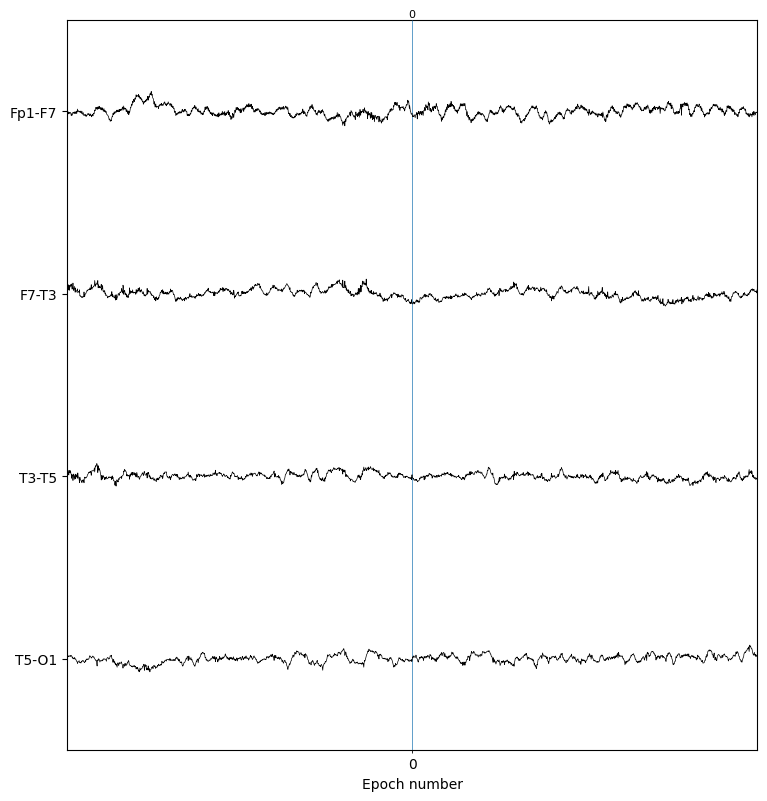

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the first epochs for all channels.
create_objects(1628180742, event_dict, DIC_BANANA)['LL'][0].plot(n_epochs=4, events=True, picks = 'all', show_scrollbars=False, show_scalebars=False, scalings=300)
plt.tight_layout()

# Generating Spectrograms with MNE


In this section, we are creating a function to convert EEG data into spectrograms. We will demonstrate this process with an example and then proceed to save all the spectrograms. 

Each spectrogram will be resized to 128x256 pixels and associated with each montage configuration and epoch (it's my wish but I couldn't with MNE time frequency function, if someone knows how to do that it will be nice). These spectrograms will be stored in a dictionary where the keys correspond to the EEG IDs. Each spectrogram will have a shape of (128x256 x number of keys in the montage dictionary x number of epochs).


## Converting EEG into spectrograms


The `spectrogram_from_eeg` function generates spectrograms from EEG data epochs provided in a dictionary format. It takes parameters such as `dic_epoch` (containing EEG epochs), `NAME_MONTAGE` (the name of the montage configuration), `num_epoch` (the index of the epoch to analyze), and `display` (a boolean indicating whether to display the spectrogram). 

1. **Frequency and Cycle Definition:**
   - The function defines the range of frequencies and the number of cycles for the Morlet wavelet transform.

2. **Morlet Wavelet Transform:**
   - It performs the Morlet wavelet transform on the EEG epoch associated with the event 'seizure' using the `tfr_morlet` function from the MNE library.

3. **Spectrogram Calculation:**
   - The spectrogram is computed for each EEG channel specified in the `DIC_MONTAGE_SPEC` dictionary.
   - Each spectrogram is normalized and stored in a list.

4. **Image Resizing:**
   - The spectrograms are averaged and resized to a lower resolution using OpenCV's `cv2.resize` function.

5. **Visualization:**
   - The resized spectrogram is displayed using Matplotlib.
   - A colorbar indicates the power intensity.
   - The function saves the spectrogram image as 'img.png'.

6. **Return:**
   - The function returns the resized spectrogram image.

In [20]:
def spectrogram_from_eeg(eeg_id, dic_epoch, DIC_MONTAGE_SPEC, display=False):
    # Define the range of frequencies
    freq = np.arange(0.1, 20, 0.01)

    # Define the number of cycles
    n_cycles = freq/2


    # Initialize the list to store the spectrograms
    spectrograms = []

    # Define the height and width of the resized image
    height = 128
    width = 256

    num_epoch = df[df['eeg_id']==1628180742].shape[0]

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((1990,2001, len(DIC_BANANA.keys()), num_epoch), dtype=np.float32)



    # Compute the spectrograms for each channel
    for j in range(num_epoch):
        index=0
        for name in DIC_BANANA_SPEC.keys():

            #  Define the Morlet wavelet transform for the epoch num_epoch associated to the event NAME_MONTAGE
            power_db = tfr_morlet(create_objects(1628180742, event_dict, DIC_BANANA)[name][j], freq, n_cycles = n_cycles, return_itc = False, picks='all', verbose=False)

            for title in range(len(DIC_BANANA_SPEC[name])):

                # Get the data array of the spectrogram
                spectrogram = power_db.data[title] 

                # Normalize the spectrogram
                spectrogram = (spectrogram + 40) / 40  
                img[:,:,index,j] += spectrogram

            # AVERAGE THE 4 MONTAGE DIFFERENCES
            img[:,:,index,j] /= len(DIC_BANANA.keys())




            if display:
                # Display the resized spectrogram
                plt.figure()
                plt.imshow(img[:,:,index,j], aspect='auto', origin='lower')
                plt.colorbar(label='Power')
                plt.xlabel('Time')
                plt.ylabel('Frequency')
                plt.title(f'EEG {1628180742} {name} {j}')
                plt.show()
            index += 1
    return img

## Example

This code generates and displays a spectrogram for EEG data associated with EEG ID `1628180742`. It uses the `create_objects` function to prepare EEG epochs and then calls `spectrogram_from_eeg` with specific parameters, including the montage configuration 'LL' and displaying the spectrogram.

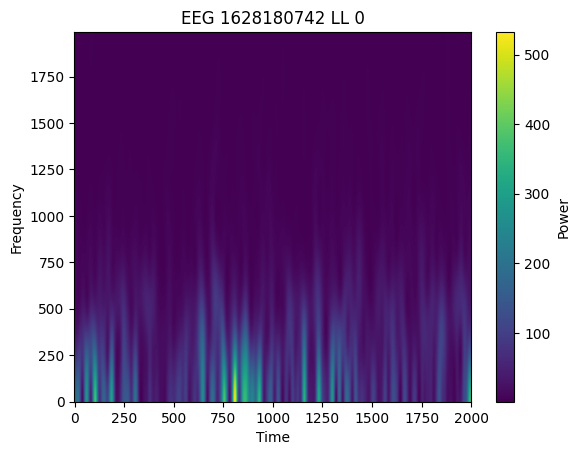

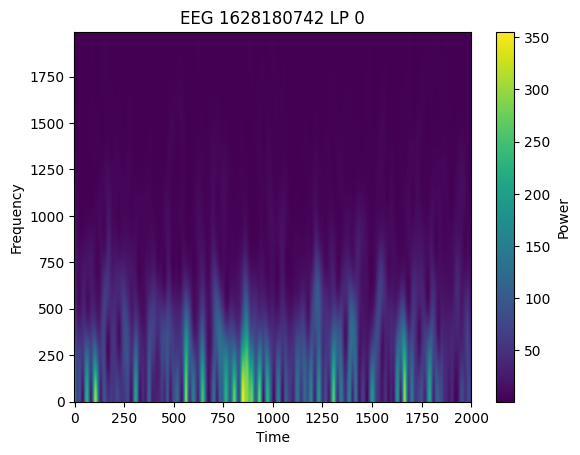

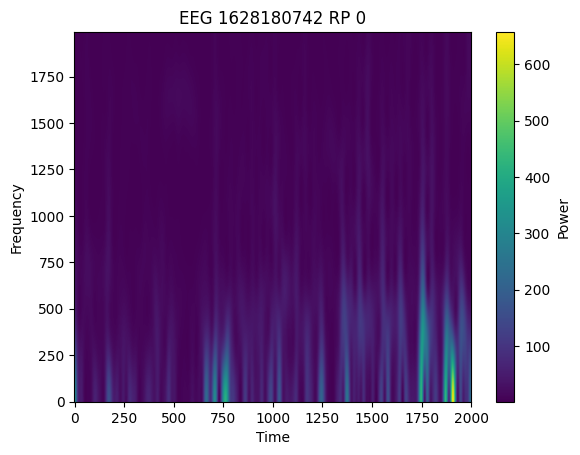

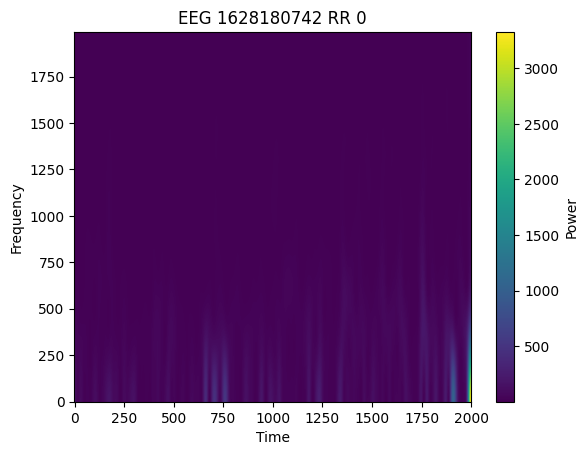

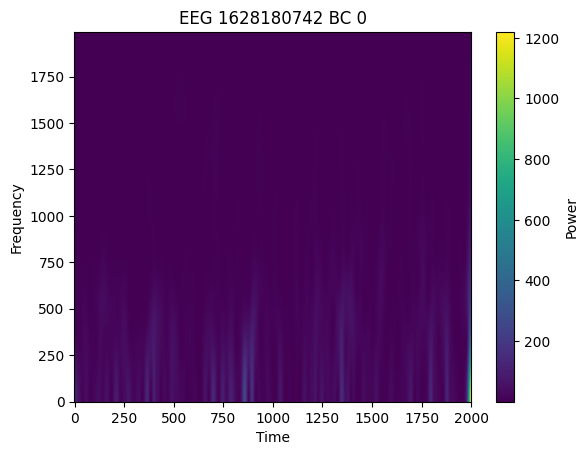

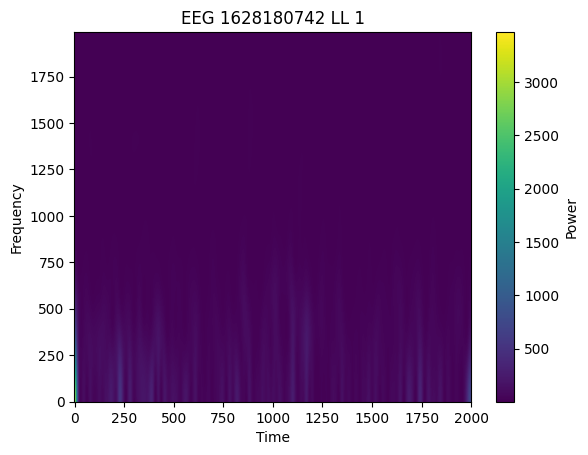

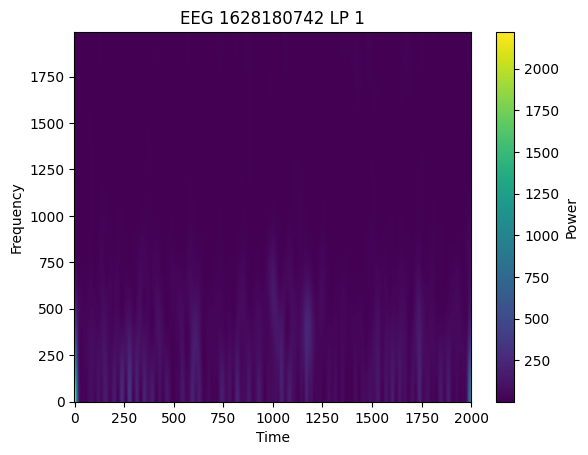

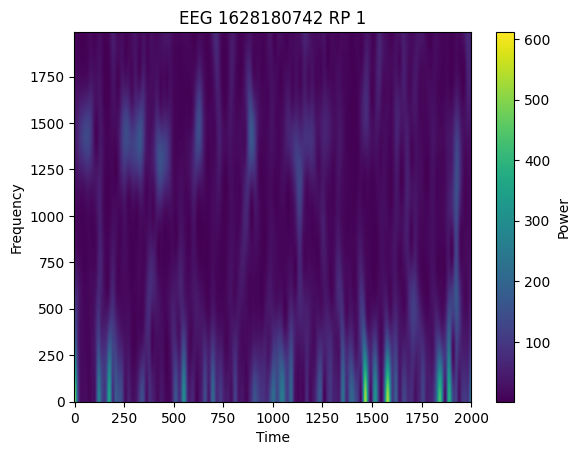

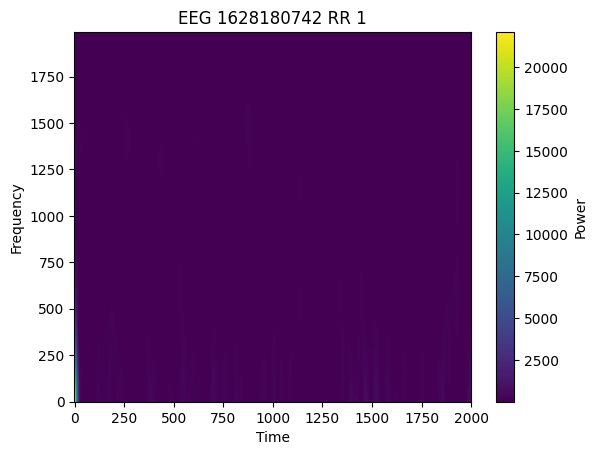

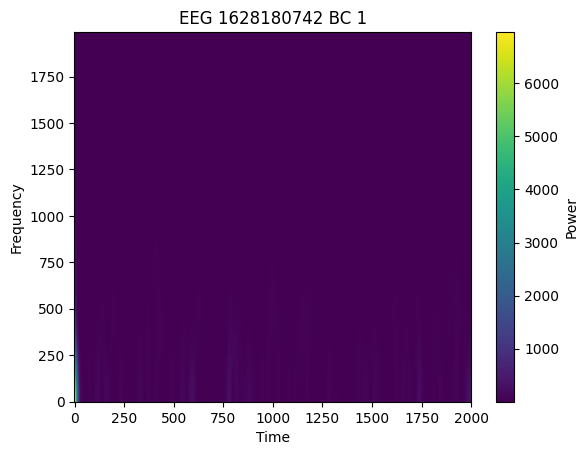

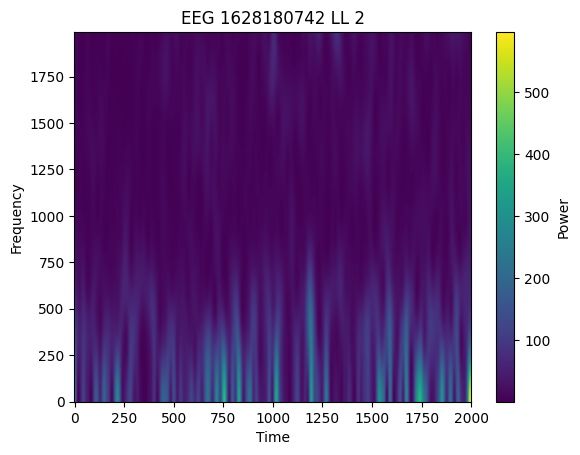

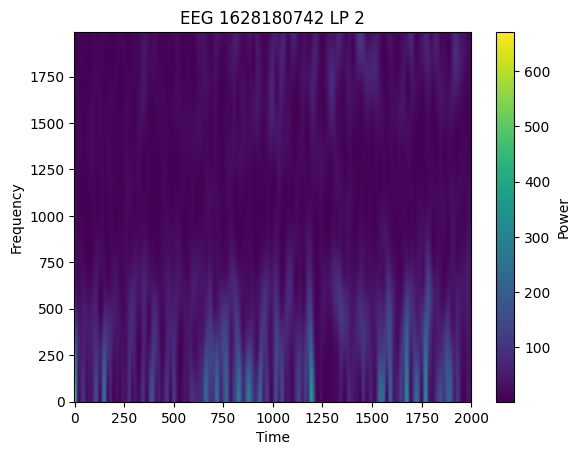

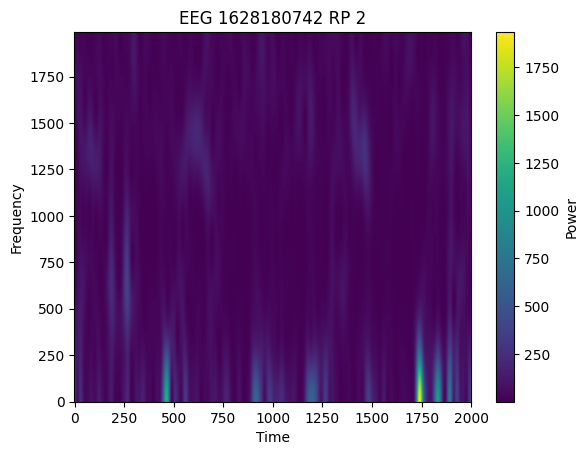

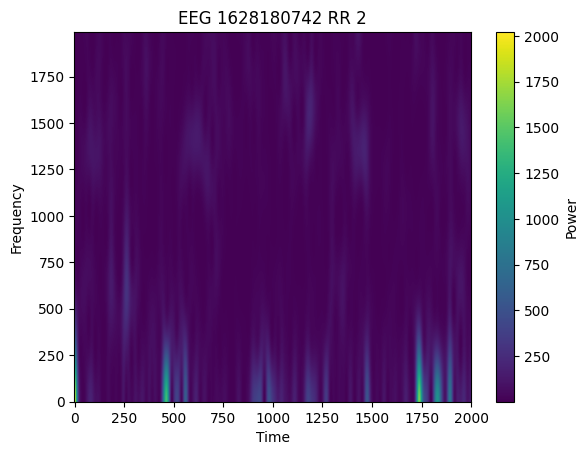

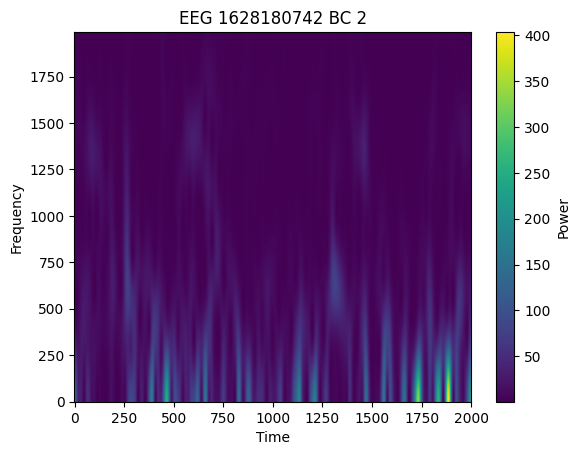

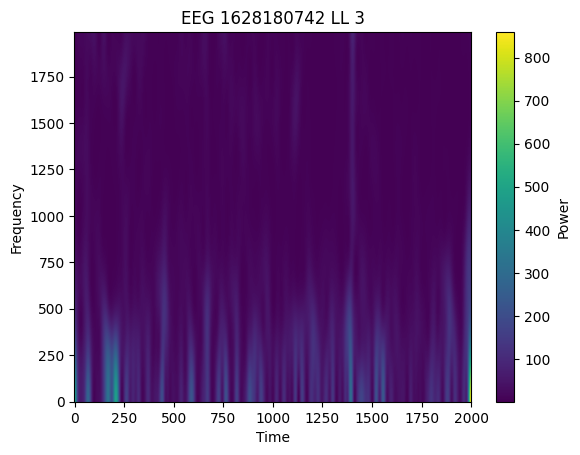

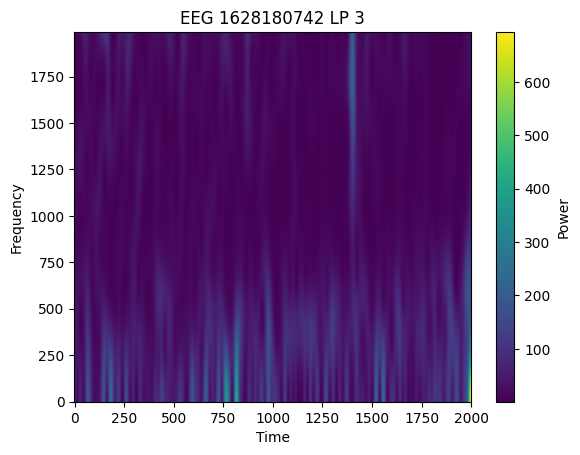

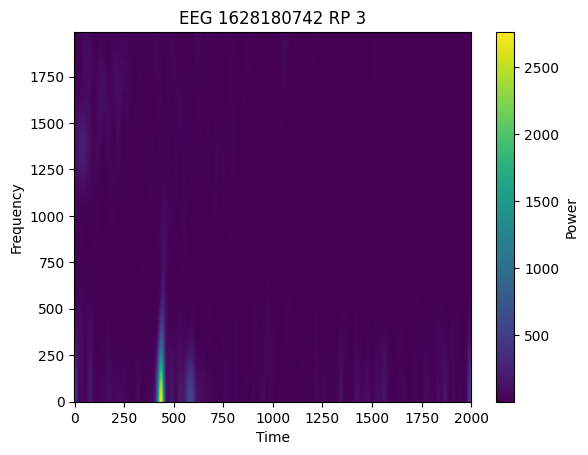

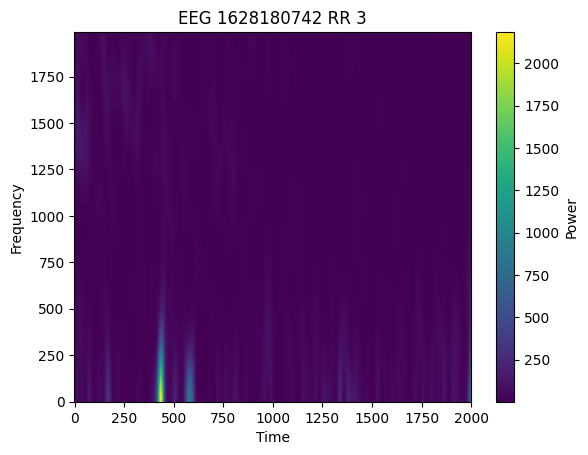

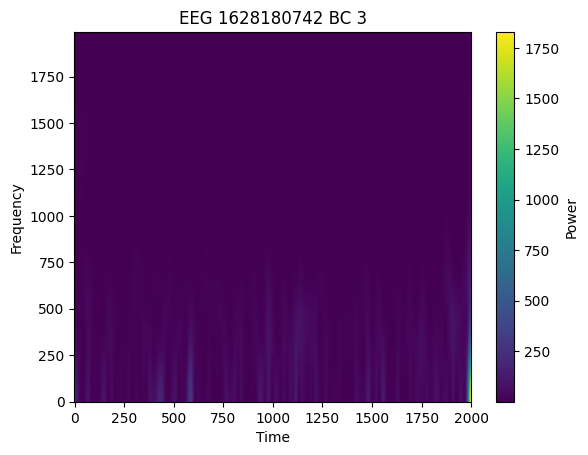

array([[[[1.68763077e+02, 3.46943994e+03, 3.64581360e+02,
          6.17583679e+02],
         [2.31593292e+02, 2.22000635e+03, 6.70834961e+02,
          1.09212502e+02],
         [3.85646973e+02, 6.11374390e+02, 3.15919373e+02,
          5.74703186e+02],
         [1.71979660e+02, 2.20996133e+04, 2.01381323e+03,
          1.04214584e+02],
         [1.00083427e+02, 6.96475488e+03, 1.49365799e+02,
          1.50682358e+02]],

        [[1.71984482e+02, 3.44163086e+03, 3.53471497e+02,
          6.07683716e+02],
         [2.22726685e+02, 2.21376929e+03, 6.59136353e+02,
          1.03453003e+02],
         [3.81948029e+02, 6.03298340e+02, 3.08648102e+02,
          5.79909546e+02],
         [1.69568161e+02, 2.19289961e+04, 2.02009058e+03,
          1.01974754e+02],
         [1.02099663e+02, 6.95048047e+03, 1.48926910e+02,
          1.55918488e+02]],

        [[1.74772507e+02, 3.38564966e+03, 3.38858185e+02,
          5.92954895e+02],
         [2.12154449e+02, 2.18926050e+03, 6.41475647e+02,
   

In [21]:
spectrogram_from_eeg(1628180742, create_objects(1628180742, event_dict, DIC_BANANA),DIC_BANANA_SPEC, display=True)

In [22]:
from tqdm import tqdm

#EEG_IDS = df.eeg_id.unique()
EEG_IDS = [1628180742, 351917269]
all_eegs = {}

print('Starting the creation of the dictionary')

# Utiliser tqdm pour visualiser la progression de la boucle
for eeg_id in tqdm(EEG_IDS):
    print(f'Starting the creation of spectrograms associated to the eeg_id {eeg_id}')    

    # Create the necessary objects to generate the spectrograms
    create_objects(eeg_id, event_dict, DIC_BANANA)

    img = spectrogram_from_eeg(eeg_id, create_objects(eeg_id, event_dict, DIC_BANANA), DIC_BANANA_SPEC, display=False).astype(np.float32)

    # Save the spectrogram array
    np.save(f'{directory_path}{eeg_id}', img)

    # Add the array of spectrograms for this EEG to the global dictionary
    all_eegs[eeg_id] = img
    print(f'Spectrograms associated to the eeg_id {eeg_id} saved')

# Save the dictionary containing all the spectrograms
np.save('eeg_specs', all_eegs)

print('Dictionary saved')


Starting the creation of the dictionary


  0%|          | 0/2 [00:00<?, ?it/s]

Starting the creation of spectrograms associated to the eeg_id 1628180742


 50%|█████     | 1/2 [00:58<00:58, 58.91s/it]

Spectrograms associated to the eeg_id 1628180742 saved
Starting the creation of spectrograms associated to the eeg_id 351917269


100%|██████████| 2/2 [01:57<00:00, 58.70s/it]

Spectrograms associated to the eeg_id 351917269 saved


Dictionary saved


# Conclusion

It appears that the process I employed to create the objects and spectrograms is time-consuming and not optimal. This slowness can largely be attributed to the significant size of the spectrograms, measuring (1990, 2001), which requires a substantial amount of resources for processing. Exploring alternatives or optimizing our current approach could greatly enhance efficiency and reduce the time required to perform these tasks.

I am open to any suggestions or ideas for improving the process of creating spectrograms or optimizing their processing. Your knowledge and expertise could help us find more effective solutions and optimize the spectrogram creation process with MNE. Feel free to share your ideas, as they could significantly contribute to our goal of improvement.

# Acknowledgement 

A significant portion of this notebook draws inspiration from the work of [@cdeotte](https://www.kaggle.com/code/cdeotte). Their insightful notebooks, particularly ["How to Make Spectrogram from EEG"](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg/notebook) served as valuable references in developing the spectrogram generation process using Librosa. We extend our gratitude to @cdeotte for their contributions to the EEG analysis community on Kaggle.

# External References

- https://www.youtube.com/watch?time_continue=5&v=l7EbPvIFWYg&embeds_referring_euri=https%3A%2F%2Ftheinformaticists.com%2F&source_ve_path=Mjg2NjY&feature=emb_logo
- https://theinformaticists.com/2020/08/25/developing-and-testing-new-montage-methods-in-electroencephalography/
- https://mne.tools/stable/index.html


# Thank you for reading! 